In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns

import lightgbm as lgb
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.preprocessing import LabelEncoder, MinMaxScaler

import warnings
import time
import sys
import datetime
from sklearn.metrics import accuracy_score, mean_squared_error
from sklearn.linear_model import BayesianRidge
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)
import gc
pd.set_option('display.width',None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_info_columns', 500)
np.random.seed(4950)

In [2]:
train = pd.read_csv("./data/pre_train_clip.csv", index_col=0)
train.drop(columns=[
    'hist_first_year', 'hist_first_quarter', 'hist_first_month',
                   ], inplace=True)

test = pd.read_csv("./data/pre_test_clip.csv", index_col=0)
test.drop(columns=[
    'hist_first_year', 'hist_first_quarter', 'hist_first_month', 
                   ], inplace=True)

cats = [
        'feature_1', 'feature_2', 'feature_3', 
        'hist_re_year', 
        'hist_re_quarter', 
#         'hist_re_month',
       ]

train[cats] = train[cats].fillna(-1, )
test[cats] = test[cats].fillna(-1, )

In [3]:
train['hist_purchase_amount_sum'].max()

486.93988132

In [4]:
train['hist_re_year'].unique()

array([2018, 2017])

In [5]:
train['hist_re_quarter'].unique()

array([1, 3, 4, 2])

In [6]:
train['hist_re_month'].unique()

array([ 2,  1,  7, 12, 10,  5,  3, 11,  9,  8,  4,  6])

In [7]:
test[test['card_id']=='C_ID_c27b4f80f7']

,first_active_month,card_id,feature_1,feature_2,feature_3,authorized_flag_mean,hist_transactions_count,hist_is_month_start_mean,hist_weekend_mean,hist_category_1_mean,hist_category_2_nunique,hist_category_3_nunique,hist_state_id_nunique,hist_city_id_nunique,hist_subsector_id_nunique,hist_merchant_category_id_nunique,hist_merchant_id_nunique,hist_quarter_nunique,hist_month_nunique,hist_weekofyear_nunique,hist_dayofweek_nunique,hist_day_nunique,hist_hour_nunique,hist_a2p_mean,hist_a2p_median,hist_a2p_max,hist_a2p_min,hist_a2p_std,hist_p2r_mean,hist_p2r_median,hist_p2r_max,hist_p2r_min,hist_p2r_std,hist_month_lag_mean,hist_month_lag_median,hist_month_lag_max,hist_month_lag_min,hist_month_lag_std,hist_purchase_amount_sum,hist_purchase_amount_mean,hist_purchase_amount_median,hist_purchase_amount_max,hist_purchase_amount_min,hist_purchase_amount_std,hist_installments_mean,hist_installments_median,hist_installments_max,hist_installments_min,hist_installments_std,hist_p_vs_m_mean,hist_p_vs_m_median,hist_p_vs_m_max,hist_p_vs_m_min,hist_p_vs_m_std,hist_p_vs_i_mean,hist_p_vs_i_median,hist_p_vs_i_max,hist_p_vs_i_min,hist_p_vs_i_std,hist_purchase_date_max,hist_purchase_date_min,hist_category_2_p_mean_mean,hist_category_2_p_mean_median,hist_category_2_p_mean_max,hist_category_2_p_mean_min,hist_category_2_p_mean_std,hist_category_3_p_mean_mean,hist_category_3_p_mean_median,hist_category_3_p_mean_max,hist_category_3_p_mean_min,hist_category_3_p_mean_std,hist_state_id_p_mean_mean,hist_state_id_p_mean_median,hist_state_id_p_mean_max,hist_state_id_p_mean_min,hist_state_id_p_mean_std,hist_city_id_p_mean_mean,hist_city_id_p_mean_median,hist_city_id_p_mean_max,hist_city_id_p_mean_min,hist_city_id_p_mean_std,hist_subsector_id_p_mean_mean,hist_subsector_id_p_mean_median,hist_subsector_id_p_mean_max,hist_subsector_id_p_mean_min,hist_subsector_id_p_mean_std,hist_merchant_category_id_p_mean_mean,hist_merchant_category_id_p_mean_median,hist_merchant_category_id_p_mean_max,hist_merchant_category_id_p_mean_min,hist_merchant_category_id_p_mean_std,hist_merchant_id_p_mean_mean,hist_merchant_id_p_mean_median,hist_merchant_id_p_mean_max,hist_merchant_id_p_mean_min,hist_merchant_id_p_mean_std,hist_quarter_p_mean_mean,hist_quarter_p_mean_median,hist_quarter_p_mean_max,hist_quarter_p_mean_min,hist_quarter_p_mean_std,hist_month_p_mean_mean,hist_month_p_mean_median,hist_month_p_mean_max,hist_month_p_mean_min,hist_month_p_mean_std,hist_weekofyear_p_mean_mean,hist_weekofyear_p_mean_median,hist_weekofyear_p_mean_max,hist_weekofyear_p_mean_min,hist_weekofyear_p_mean_std,hist_dayofweek_p_mean_mean,hist_dayofweek_p_mean_median,hist_dayofweek_p_mean_max,hist_dayofweek_p_mean_min,hist_dayofweek_p_mean_std,hist_day_p_mean_mean,hist_day_p_mean_median,hist_day_p_mean_max,hist_day_p_mean_min,hist_day_p_mean_std,hist_hour_p_mean_mean,hist_hour_p_mean_median,hist_hour_p_mean_max,hist_hour_p_mean_min,hist_hour_p_mean_std,hist_re_year,hist_re_quarter,hist_re_month,hist_a2r,hist_p2p,hist_sleep,hist_p2p_vs_count,hist_sleep_vs_count,hist_p2r_vs_count,hist_count_vs_p2p,hist_sleep_vs_p2p,hist_p_vs_p2p,hist_count_vs_p2r,hist_sleep_vs_p2r,hist_p_vs_p2r,new_transactions_count,new_is_month_start_mean,new_weekend_mean,new_category_1_mean,new_category_2_nunique,new_category_3_nunique,new_state_id_nunique,new_city_id_nunique,new_subsector_id_nunique,new_merchant_category_id_nunique,new_merchant_id_nunique,new_quarter_nunique,new_month_nunique,new_weekofyear_nunique,new_dayofweek_nunique,new_day_nunique,new_hour_nunique,new_a2p_mean,new_a2p_median,new_a2p_max,new_a2p_min,new_a2p_std,new_p2r_mean,new_p2r_median,new_p2r_max,new_p2r_min,new_p2r_std,new_month_lag_mean,new_month_lag_median,new_month_lag_max,new_month_lag_min,new_month_lag_std,new_purchase_amount_sum,new_purchase_amount_mean,new_purchase_amount_median,new_purchase_amount_max,new_purchase_amount_min,new_purchase_amount_std,new_installments_mean,new_installments_median,new_installments_max,new_installments_min,new_installments_std,new

In [8]:
data = pd.concat([train, test])    
data.reset_index(drop=True, inplace=True)

for feat in cats:
    lbe = LabelEncoder()
    data[feat] = lbe.fit_transform(data[feat])
#     data[feat][data[feat]>=0] = lbe.fit_transform(data[feat][data[feat]>=0])

In [9]:
train[cats] = data[0:201917][cats]

In [10]:
tmp = data[201917:][cats].reset_index(drop=True)
test[cats] = tmp

In [11]:
for c in cats:
    print(train[c].unique())
    print(test[c].unique())
    print(data[c].unique())

[4 3 1 0 2]
[2 1 4 0 3]
[4 3 1 0 2]
[1 0 2]
[2 0 1]
[1 0 2]
[1 0]
[1 0]
[1 0]
[1 0]
[0 1]
[1 0]
[0 2 3 1]
[3 0 2 1]
[0 2 3 1]


In [12]:
train.head()

,first_active_month,card_id,feature_1,feature_2,feature_3,target,authorized_flag_mean,hist_transactions_count,hist_is_month_start_mean,hist_weekend_mean,hist_category_1_mean,hist_category_2_nunique,hist_category_3_nunique,hist_state_id_nunique,hist_city_id_nunique,hist_subsector_id_nunique,hist_merchant_category_id_nunique,hist_merchant_id_nunique,hist_quarter_nunique,hist_month_nunique,hist_weekofyear_nunique,hist_dayofweek_nunique,hist_day_nunique,hist_hour_nunique,hist_a2p_mean,hist_a2p_median,hist_a2p_max,hist_a2p_min,hist_a2p_std,hist_p2r_mean,hist_p2r_median,hist_p2r_max,hist_p2r_min,hist_p2r_std,hist_month_lag_mean,hist_month_lag_median,hist_month_lag_max,hist_month_lag_min,hist_month_lag_std,hist_purchase_amount_sum,hist_purchase_amount_mean,hist_purchase_amount_median,hist_purchase_amount_max,hist_purchase_amount_min,hist_purchase_amount_std,hist_installments_mean,hist_installments_median,hist_installments_max,hist_installments_min,hist_installments_std,hist_p_vs_m_mean,hist_p_vs_m_median,hist_p_vs_m_max,hist_p_vs_m_min,hist_p_vs_m_std,hist_p_vs_i_mean,hist_p_vs_i_median,hist_p_vs_i_max,hist_p_vs_i_min,hist_p_vs_i_std,hist_purchase_date_max,hist_purchase_date_min,hist_category_2_p_mean_mean,hist_category_2_p_mean_median,hist_category_2_p_mean_max,hist_category_2_p_mean_min,hist_category_2_p_mean_std,hist_category_3_p_mean_mean,hist_category_3_p_mean_median,hist_category_3_p_mean_max,hist_category_3_p_mean_min,hist_category_3_p_mean_std,hist_state_id_p_mean_mean,hist_state_id_p_mean_median,hist_state_id_p_mean_max,hist_state_id_p_mean_min,hist_state_id_p_mean_std,hist_city_id_p_mean_mean,hist_city_id_p_mean_median,hist_city_id_p_mean_max,hist_city_id_p_mean_min,hist_city_id_p_mean_std,hist_subsector_id_p_mean_mean,hist_subsector_id_p_mean_median,hist_subsector_id_p_mean_max,hist_subsector_id_p_mean_min,hist_subsector_id_p_mean_std,hist_merchant_category_id_p_mean_mean,hist_merchant_category_id_p_mean_median,hist_merchant_category_id_p_mean_max,hist_merchant_category_id_p_mean_min,hist_merchant_category_id_p_mean_std,hist_merchant_id_p_mean_mean,hist_merchant_id_p_mean_median,hist_merchant_id_p_mean_max,hist_merchant_id_p_mean_min,hist_merchant_id_p_mean_std,hist_quarter_p_mean_mean,hist_quarter_p_mean_median,hist_quarter_p_mean_max,hist_quarter_p_mean_min,hist_quarter_p_mean_std,hist_month_p_mean_mean,hist_month_p_mean_median,hist_month_p_mean_max,hist_month_p_mean_min,hist_month_p_mean_std,hist_weekofyear_p_mean_mean,hist_weekofyear_p_mean_median,hist_weekofyear_p_mean_max,hist_weekofyear_p_mean_min,hist_weekofyear_p_mean_std,hist_dayofweek_p_mean_mean,hist_dayofweek_p_mean_median,hist_dayofweek_p_mean_max,hist_dayofweek_p_mean_min,hist_dayofweek_p_mean_std,hist_day_p_mean_mean,hist_day_p_mean_median,hist_day_p_mean_max,hist_day_p_mean_min,hist_day_p_mean_std,hist_hour_p_mean_mean,hist_hour_p_mean_median,hist_hour_p_mean_max,hist_hour_p_mean_min,hist_hour_p_mean_std,hist_re_year,hist_re_quarter,hist_re_month,hist_a2r,hist_p2p,hist_sleep,hist_p2p_vs_count,hist_sleep_vs_count,hist_p2r_vs_count,hist_count_vs_p2p,hist_sleep_vs_p2p,hist_p_vs_p2p,hist_count_vs_p2r,hist_sleep_vs_p2r,hist_p_vs_p2r,new_transactions_count,new_is_month_start_mean,new_weekend_mean,new_category_1_mean,new_category_2_nunique,new_category_3_nunique,new_state_id_nunique,new_city_id_nunique,new_subsector_id_nunique,new_merchant_category_id_nunique,new_merchant_id_nunique,new_quarter_nunique,new_month_nunique,new_weekofyear_nunique,new_dayofweek_nunique,new_day_nunique,new_hour_nunique,new_a2p_mean,new_a2p_median,new_a2p_max,new_a2p_min,new_a2p_std,new_p2r_mean,new_p2r_median,new_p2r_max,new_p2r_min,new_p2r_std,new_month_lag_mean,new_month_lag_median,new_month_lag_max,new_month_lag_min,new_month_lag_std,new_purchase_amount_sum,new_purchase_amount_mean,new_purchase_amount_median,new_purchase_amount_max,new_purchase_amount_min,new_purchase_amount_std,new_installments_mean,new_installments_median,new_installments_max,new_installments_min,new_installments_

In [13]:
test.head()

,first_active_month,card_id,feature_1,feature_2,feature_3,authorized_flag_mean,hist_transactions_count,hist_is_month_start_mean,hist_weekend_mean,hist_category_1_mean,hist_category_2_nunique,hist_category_3_nunique,hist_state_id_nunique,hist_city_id_nunique,hist_subsector_id_nunique,hist_merchant_category_id_nunique,hist_merchant_id_nunique,hist_quarter_nunique,hist_month_nunique,hist_weekofyear_nunique,hist_dayofweek_nunique,hist_day_nunique,hist_hour_nunique,hist_a2p_mean,hist_a2p_median,hist_a2p_max,hist_a2p_min,hist_a2p_std,hist_p2r_mean,hist_p2r_median,hist_p2r_max,hist_p2r_min,hist_p2r_std,hist_month_lag_mean,hist_month_lag_median,hist_month_lag_max,hist_month_lag_min,hist_month_lag_std,hist_purchase_amount_sum,hist_purchase_amount_mean,hist_purchase_amount_median,hist_purchase_amount_max,hist_purchase_amount_min,hist_purchase_amount_std,hist_installments_mean,hist_installments_median,hist_installments_max,hist_installments_min,hist_installments_std,hist_p_vs_m_mean,hist_p_vs_m_median,hist_p_vs_m_max,hist_p_vs_m_min,hist_p_vs_m_std,hist_p_vs_i_mean,hist_p_vs_i_median,hist_p_vs_i_max,hist_p_vs_i_min,hist_p_vs_i_std,hist_purchase_date_max,hist_purchase_date_min,hist_category_2_p_mean_mean,hist_category_2_p_mean_median,hist_category_2_p_mean_max,hist_category_2_p_mean_min,hist_category_2_p_mean_std,hist_category_3_p_mean_mean,hist_category_3_p_mean_median,hist_category_3_p_mean_max,hist_category_3_p_mean_min,hist_category_3_p_mean_std,hist_state_id_p_mean_mean,hist_state_id_p_mean_median,hist_state_id_p_mean_max,hist_state_id_p_mean_min,hist_state_id_p_mean_std,hist_city_id_p_mean_mean,hist_city_id_p_mean_median,hist_city_id_p_mean_max,hist_city_id_p_mean_min,hist_city_id_p_mean_std,hist_subsector_id_p_mean_mean,hist_subsector_id_p_mean_median,hist_subsector_id_p_mean_max,hist_subsector_id_p_mean_min,hist_subsector_id_p_mean_std,hist_merchant_category_id_p_mean_mean,hist_merchant_category_id_p_mean_median,hist_merchant_category_id_p_mean_max,hist_merchant_category_id_p_mean_min,hist_merchant_category_id_p_mean_std,hist_merchant_id_p_mean_mean,hist_merchant_id_p_mean_median,hist_merchant_id_p_mean_max,hist_merchant_id_p_mean_min,hist_merchant_id_p_mean_std,hist_quarter_p_mean_mean,hist_quarter_p_mean_median,hist_quarter_p_mean_max,hist_quarter_p_mean_min,hist_quarter_p_mean_std,hist_month_p_mean_mean,hist_month_p_mean_median,hist_month_p_mean_max,hist_month_p_mean_min,hist_month_p_mean_std,hist_weekofyear_p_mean_mean,hist_weekofyear_p_mean_median,hist_weekofyear_p_mean_max,hist_weekofyear_p_mean_min,hist_weekofyear_p_mean_std,hist_dayofweek_p_mean_mean,hist_dayofweek_p_mean_median,hist_dayofweek_p_mean_max,hist_dayofweek_p_mean_min,hist_dayofweek_p_mean_std,hist_day_p_mean_mean,hist_day_p_mean_median,hist_day_p_mean_max,hist_day_p_mean_min,hist_day_p_mean_std,hist_hour_p_mean_mean,hist_hour_p_mean_median,hist_hour_p_mean_max,hist_hour_p_mean_min,hist_hour_p_mean_std,hist_re_year,hist_re_quarter,hist_re_month,hist_a2r,hist_p2p,hist_sleep,hist_p2p_vs_count,hist_sleep_vs_count,hist_p2r_vs_count,hist_count_vs_p2p,hist_sleep_vs_p2p,hist_p_vs_p2p,hist_count_vs_p2r,hist_sleep_vs_p2r,hist_p_vs_p2r,new_transactions_count,new_is_month_start_mean,new_weekend_mean,new_category_1_mean,new_category_2_nunique,new_category_3_nunique,new_state_id_nunique,new_city_id_nunique,new_subsector_id_nunique,new_merchant_category_id_nunique,new_merchant_id_nunique,new_quarter_nunique,new_month_nunique,new_weekofyear_nunique,new_dayofweek_nunique,new_day_nunique,new_hour_nunique,new_a2p_mean,new_a2p_median,new_a2p_max,new_a2p_min,new_a2p_std,new_p2r_mean,new_p2r_median,new_p2r_max,new_p2r_min,new_p2r_std,new_month_lag_mean,new_month_lag_median,new_month_lag_max,new_month_lag_min,new_month_lag_std,new_purchase_amount_sum,new_purchase_amount_mean,new_purchase_amount_median,new_purchase_amount_max,new_purchase_amount_min,new_purchase_amount_std,new_installments_mean,new_installments_median,new_installments_max,new_installments_min,new_installments_std,new

In [14]:
fold_target = train['target']
fold_target = (fold_target<-20).astype(int)

In [15]:
# mean_encodes = ['category_2','category_3', 
#                 'state_id', 'city_id', 'subsector_id', 'merchant_category_id', 'merchant_id', 
#                 'year', 'quarter', 'month', 'weekofyear', 'dayofweek', 'hour']

# aggs = ['sum', 'mean', 'median', 'max', 'min', 'std']

# mean_encode_cols = ['hist_'+i+'_mean_'+j for i in mean_encodes for j in aggs] + ['new_'+i+'_mean_'+j for i in mean_encodes for j in aggs]

# print(mean_encode_cols)

In [16]:
def get_feature_importances(data, shuffle, seed=None):
    train_features = [c for c in data.columns if c not in ['card_id', 'first_active_month', 'target','outliers']]

    y = data['target'].copy()
    if shuffle:
        # Here you could as well use a binomial distribution
        y = data['target'].copy().sample(frac=1.0)
    
    # Fit LightGBM in RF mode, yes it's quicker than sklearn RandomForest
    
#     dtrain = lgb.Dataset(data[train_features], y, free_raw_data=False, silent=True)

    dtrain = lgb.Dataset(data[train_features], y, categorical_feature=cats, free_raw_data=False, silent=True)

    lgb_params = {
         'objective':'regression',
         "boosting": "gbdt",
         'num_leaves': 31,
         'min_data_in_leaf': 30, 
         'max_depth': -1,
         'learning_rate': 0.01,
         "lambda_l1": 0.1,
         "feature_fraction": 0.9,
         "bagging_fraction": 0.9,
         "bagging_freq": 1,
         "bagging_seed": 11,
         "random_state": 4950,
         "verbosity": -1,
    }
    
    # Fit the model
    clf = lgb.train(params=lgb_params, train_set=dtrain, num_boost_round=400)

    # Get feature importances
    imp_df = pd.DataFrame()
    imp_df["feature"] = list(train_features)
    imp_df["importance_gain"] = clf.feature_importance(importance_type='gain')
    imp_df["importance_split"] = clf.feature_importance(importance_type='split')
    imp_df['trn_score'] = mean_squared_error(y, clf.predict(data[train_features]))**0.5
    
    return imp_df

In [17]:
actual_imp_df = get_feature_importances(data=train, shuffle=False)

In [18]:
actual_imp_df.sort_values('importance_split', ascending=False)

,feature,importance_gain,importance_split,trn_score
3,authorized_flag_mean,5.231946e+05,359,3.486401
272,c_p_diff,8.238508e+05,336,3.486401
163,new_p2r_max,1.346225e+06,311,3.486401
16,hist_month_nunique,1.238666e+06,298,3.486401
126,hist_re_month,2.977899e+06,297,3.486401
7,hist_category_1_mean,1.383668e+06,243,3.486401
142,new_category_1_mean,4.249093e+05,229,3.486401
57,hist_purchase_date_max,2.943400e+05,219,3.486401
17,hist_weekofyear_nunique,6.572547e+05,181,3.486401
285,p2r_count_diff_vs,2.188465e+05,152,3.486401


In [19]:
# np.percentile(actual_imp_df['importance_split'], [1, 5, 10, 50, 99])

In [20]:
# actual_imp_df = actual_imp_df[actual_imp_df['importance_split'] != 0]

In [21]:
# actual_imp_df.count()

In [22]:
null_imp_df = pd.DataFrame()
nb_runs = 1024
import time
start = time.time()
dsp = ''
for i in range(nb_runs):
    # Get current run importances
    imp_df = get_feature_importances(data=train, shuffle=True)
    imp_df['run'] = i + 1 
    # Concat the latest importances with the old ones
    null_imp_df = pd.concat([null_imp_df, imp_df], axis=0)
    # Erase previous message
    for l in range(len(dsp)):
        print('\b', end='', flush=True)
    # Display current run and time used
    spent = (time.time() - start) / 60
    dsp = 'Done with %4d of %4d (Spent %5.1f min)' % (i + 1, nb_runs, spent)
    print(dsp, end='', flush=True)

Done with

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Done with  382 of 1024 (Spen

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Done with 1024 of 1024 (Spent 632.5 min)

In [23]:
null_imp_df.head()

,feature,importance_gain,importance_split,trn_score,run
0,feature_1,1620.686981,8,3.798702,1
1,feature_2,6088.320038,14,3.798702,1
2,feature_3,3580.494034,7,3.798702,1
3,authorized_flag_mean,33077.436356,88,3.798702,1
4,hist_transactions_count,12899.210945,41,3.798702,1


In [24]:
def display_distributions(actual_imp_df_, null_imp_df_, feature_):
    plt.figure(figsize=(13, 6))
    gs = gridspec.GridSpec(1, 2)
    # Plot Split importances
    ax = plt.subplot(gs[0, 0])
    a = ax.hist(null_imp_df_.loc[null_imp_df_['feature'] == feature_, 'importance_split'].values, label='Null importances')
    ax.vlines(x=actual_imp_df_.loc[actual_imp_df_['feature'] == feature_, 'importance_split'].mean(), 
               ymin=0, ymax=np.max(a[0]), color='r',linewidth=10, label='Real Target')
    ax.legend()
    ax.set_title('Split Importance of %s' % feature_.upper(), fontweight='bold')
    plt.xlabel('Null Importance (split) Distribution for %s ' % feature_.upper())
    # Plot Gain importances
    ax = plt.subplot(gs[0, 1])
    a = ax.hist(null_imp_df_.loc[null_imp_df_['feature'] == feature_, 'importance_gain'].values, label='Null importances')
    ax.vlines(x=actual_imp_df_.loc[actual_imp_df_['feature'] == feature_, 'importance_gain'].mean(), 
               ymin=0, ymax=np.max(a[0]), color='r',linewidth=10, label='Real Target')
    ax.legend()
    ax.set_title('Gain Importance of %s' % feature_.upper(), fontweight='bold')
    plt.xlabel('Null Importance (gain) Distribution for %s ' % feature_.upper())

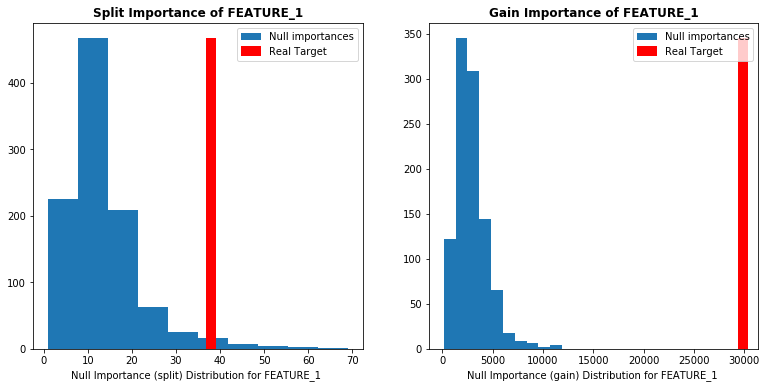

In [25]:
display_distributions(actual_imp_df_=actual_imp_df, null_imp_df_=null_imp_df, feature_='feature_1')

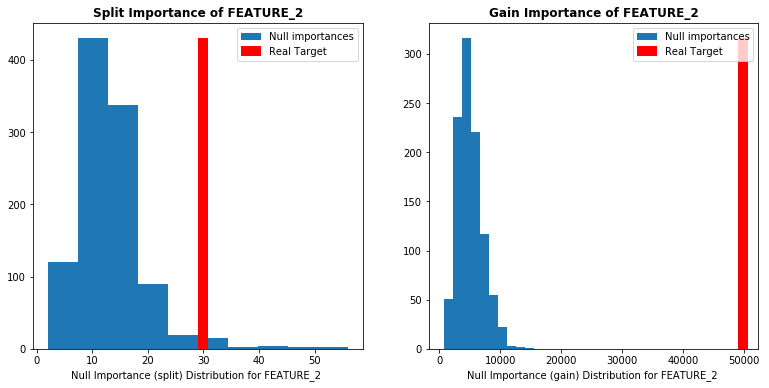

In [26]:
display_distributions(actual_imp_df_=actual_imp_df, null_imp_df_=null_imp_df, feature_='feature_2')

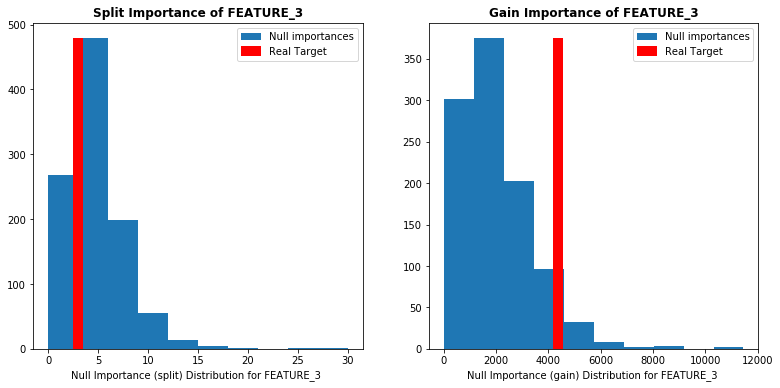

In [27]:
display_distributions(actual_imp_df_=actual_imp_df, null_imp_df_=null_imp_df, feature_='feature_3')

In [28]:
# display_distributions(actual_imp_df_=actual_imp_df, null_imp_df_=null_imp_df, feature_='hist_category_3_p_mean_max')

In [29]:
# display_distributions(actual_imp_df_=actual_imp_df, null_imp_df_=null_imp_df, feature_='hist_category_3_p_mean_min')

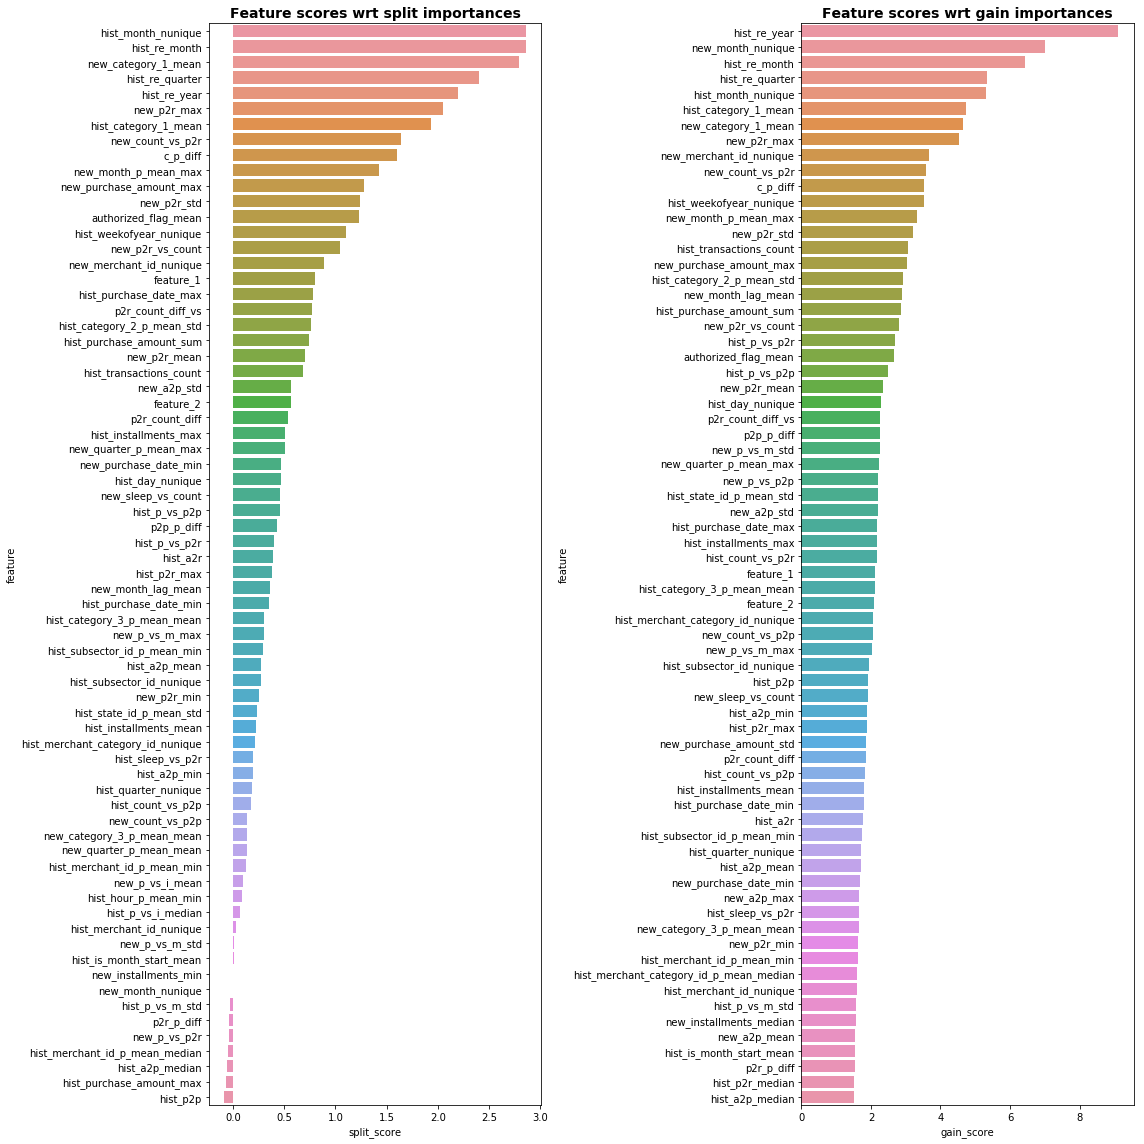

In [30]:
feature_scores = []
for _f in actual_imp_df['feature'].unique():
    f_null_imps_gain = null_imp_df.loc[null_imp_df['feature'] == _f, 'importance_gain'].values
    f_act_imps_gain = actual_imp_df.loc[actual_imp_df['feature'] == _f, 'importance_gain'].mean()
    gain_score = np.log(1e-10 + f_act_imps_gain / (1 + np.percentile(f_null_imps_gain, 75)))  # Avoid didvide by zero
    f_null_imps_split = null_imp_df.loc[null_imp_df['feature'] == _f, 'importance_split'].values
    f_act_imps_split = actual_imp_df.loc[actual_imp_df['feature'] == _f, 'importance_split'].mean()
    split_score = np.log(1e-10 + f_act_imps_split / (1 + np.percentile(f_null_imps_split, 75)))  # Avoid didvide by zero
    feature_scores.append((_f, split_score, gain_score))

scores_df = pd.DataFrame(feature_scores, columns=['feature', 'split_score', 'gain_score'])

plt.figure(figsize=(16, 16))
gs = gridspec.GridSpec(1, 2)
# Plot Split importances
ax = plt.subplot(gs[0, 0])
sns.barplot(x='split_score', y='feature', data=scores_df.sort_values('split_score', ascending=False).iloc[0:70], ax=ax)
ax.set_title('Feature scores wrt split importances', fontweight='bold', fontsize=14)
# Plot Gain importances
ax = plt.subplot(gs[0, 1])
sns.barplot(x='gain_score', y='feature', data=scores_df.sort_values('gain_score', ascending=False).iloc[0:70], ax=ax)
ax.set_title('Feature scores wrt gain importances', fontweight='bold', fontsize=14)
plt.tight_layout()

In [31]:
scores_df['split_score'].max()

2.863880142454893

In [32]:
scores_df['split_score'].min()

-23.025850929940457

In [33]:
null_imp_df.to_csv('null_importances_distribution_gbdt_1024.csv')
actual_imp_df.to_csv('actual_importances_ditribution_gbdt_1024.csv')

In [34]:
null_imp_df = pd.read_csv('null_importances_distribution_gbdt_1024.csv', index_col=0)
actual_imp_df = pd.read_csv('actual_importances_ditribution_gbdt_1024.csv', index_col=0)

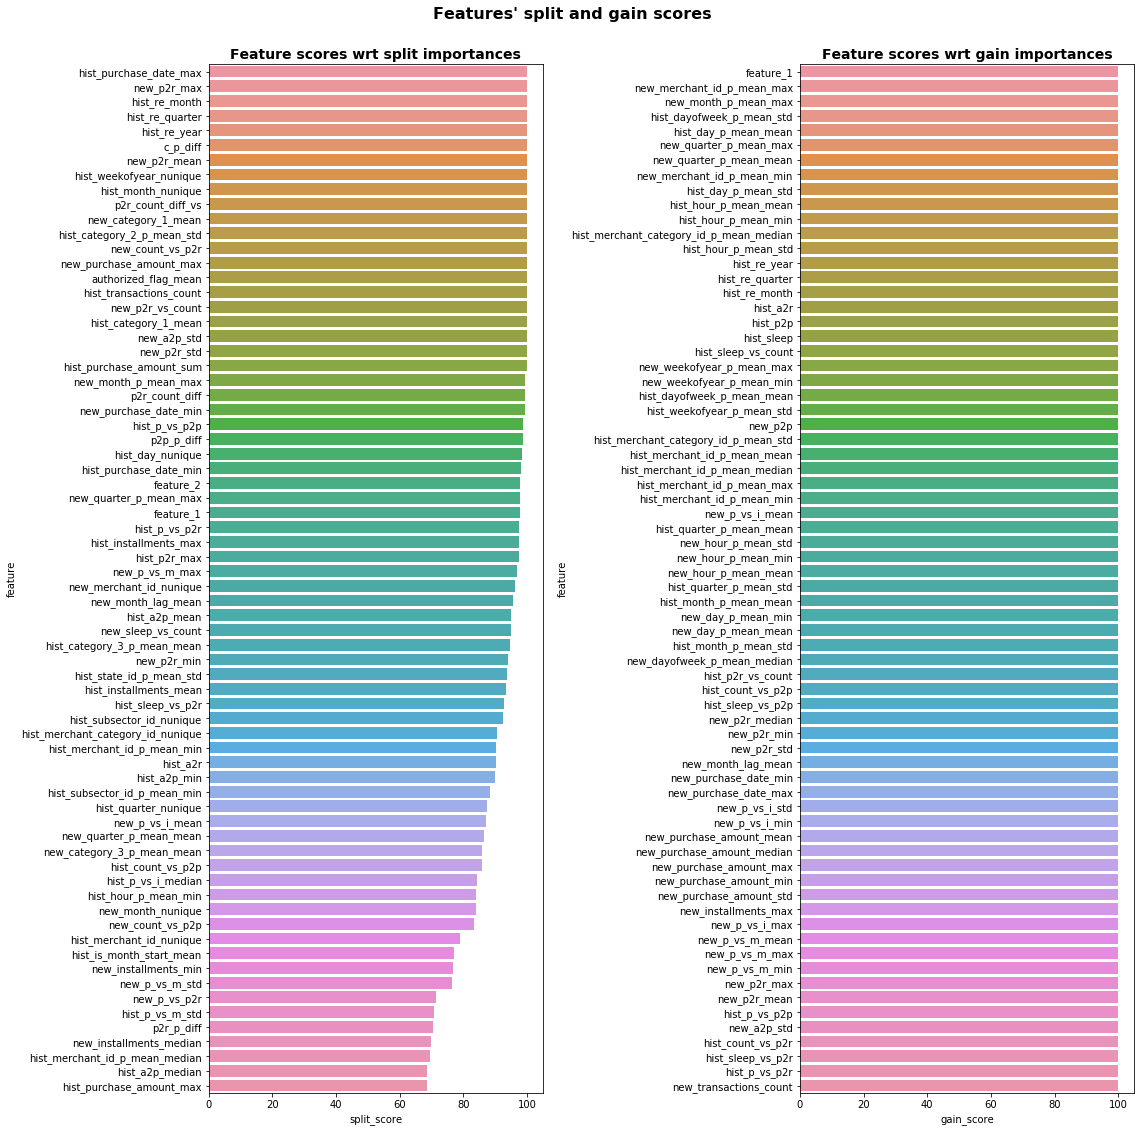

In [35]:
correlation_scores = []
for _f in actual_imp_df['feature'].unique():
    f_null_imps = null_imp_df.loc[null_imp_df['feature'] == _f, 'importance_gain'].values
    f_act_imps = actual_imp_df.loc[actual_imp_df['feature'] == _f, 'importance_gain'].values
    gain_score = 100 * (f_null_imps < np.percentile(f_act_imps, 25)).sum() / f_null_imps.size
    f_null_imps = null_imp_df.loc[null_imp_df['feature'] == _f, 'importance_split'].values
    f_act_imps = actual_imp_df.loc[actual_imp_df['feature'] == _f, 'importance_split'].values
    split_score = 100 * (f_null_imps < np.percentile(f_act_imps, 25)).sum() / f_null_imps.size ########
    correlation_scores.append((_f, split_score, gain_score))

corr_scores_df = pd.DataFrame(correlation_scores, columns=['feature', 'split_score', 'gain_score'])

fig = plt.figure(figsize=(16, 16))
gs = gridspec.GridSpec(1, 2)
# Plot Split importances
ax = plt.subplot(gs[0, 0])
sns.barplot(x='split_score', y='feature', data=corr_scores_df.sort_values('split_score', ascending=False).iloc[0:70], ax=ax)
ax.set_title('Feature scores wrt split importances', fontweight='bold', fontsize=14)
# Plot Gain importances
ax = plt.subplot(gs[0, 1])
sns.barplot(x='gain_score', y='feature', data=corr_scores_df.sort_values('gain_score', ascending=False).iloc[0:70], ax=ax)
ax.set_title('Feature scores wrt gain importances', fontweight='bold', fontsize=14)
plt.tight_layout()
plt.suptitle("Features' split and gain scores", fontweight='bold', fontsize=16)
fig.subplots_adjust(top=0.93)

In [36]:
corr_scores_df.count()

feature        288
split_score    288
gain_score     288
dtype: int64

In [37]:
def score_feature_selection(df=None, train_features=None, cat_feats=None, target=None):
    # Fit LightGBM 
    lgb_params = {
         'objective':'regression',
         "metric": 'rmse',
         "boosting": "gbdt",
         'num_leaves': 31,
         'min_data_in_leaf': 30, 
         'max_depth': -1,
         'learning_rate': 0.01,
         "lambda_l1": 0.1,
         "feature_fraction": 0.9,
         "bagging_fraction": 0.9 ,
         "bagging_freq": 1,
         "bagging_seed": 11,
         "random_state": 4950,
         "verbosity": -1,
    }
    
    oof = np.zeros(len(df))
    folds = StratifiedKFold(n_splits=7, shuffle=True, random_state=4590)
        
    for fold_, (trn_idx, val_idx) in enumerate(folds.split(df, fold_target)):
#         print("fold n°{}".format(fold_))

        trn_data = lgb.Dataset(df.iloc[trn_idx][train_features], label=target.iloc[trn_idx], categorical_feature=cat_feats, silent=True)
#         trn_data = lgb.Dataset(df.iloc[trn_idx][train_features], label=target.iloc[trn_idx], silent=True)

        val_data = lgb.Dataset(df.iloc[val_idx][train_features], label=target.iloc[val_idx], categorical_feature=cat_feats, silent=True)
#         val_data = lgb.Dataset(df.iloc[val_idx][train_features], label=target.iloc[val_idx], silent=True)

        num_round = 10000
        clf = lgb.train(lgb_params, trn_data, num_round, valid_sets = [trn_data, val_data],
                    verbose_eval=0, early_stopping_rounds = 200)
        oof[val_idx] = clf.predict(df.iloc[val_idx][train_features], num_iteration=clf.best_iteration)
    
    mse = mean_squared_error(oof, target.values.reshape(-1))
    
    return mse**0.5, mse


for threshold in [99, 95, 90, 85, 80, 75, 70, 65, 60, 55, 50, 45, 40, 35, 30, 25, 20, 15, 10, 5]:
# for threshold in [0, 10, 20, 30 , 40, 50 ,60 , 70, 80 , 90, 95, 99]:
    split_feats = [_f for _f, _score, _ in correlation_scores if _score >= threshold]
    split_cat_feats = [_f for _f, _score, _ in correlation_scores if (_score >= threshold) & (_f in cats)]
    gain_feats = [_f for _f, _, _score in correlation_scores if _score >= threshold]
    gain_cat_feats = [_f for _f, _, _score in correlation_scores if (_score >= threshold) & (_f in cats)]
                                                                                             
    print('Results for threshold %3d' % threshold)
    
    split_results = score_feature_selection(df=train, train_features=split_feats, cat_feats=split_cat_feats, target=train['target'])
#     split_results = score_feature_selection(df=train, train_features=split_feats, target=train['target'])
    print('\t SPLIT : %.6f +/- %.6f' % (split_results[0], split_results[1]))
    
    gain_results = score_feature_selection(df=train, train_features=gain_feats, cat_feats=gain_cat_feats, target=train['target'])
#     gain_results = score_feature_selection(df=train, train_features=gain_feats, target=train['target'])
    print('\t GAIN  : %.6f +/- %.6f' % (gain_results[0], gain_results[1]))

Results for threshold  99
	 SPLIT : 3.652922 +/- 13.343840
	 GAIN  : 3.643312 +/- 13.273724
Results for threshold  95
	 SPLIT : 3.647406 +/- 13.303571
	 GAIN  : 3.643400 +/- 13.274361
Results for threshold  90
	 SPLIT : 3.644546 +/- 13.282715
	 GAIN  : 3.644514 +/- 13.282485
Results for threshold  85
	 SPLIT : 3.643975 +/- 13.278554
	 GAIN  : 3.645701 +/- 13.291134
Results for threshold  80
	 SPLIT : 3.643126 +/- 13.272369
	 GAIN  : 3.643828 +/- 13.277483
Results for threshold  75
	 SPLIT : 3.642816 +/- 13.270110
	 GAIN  : 3.643349 +/- 13.273995
Results for threshold  70
	 SPLIT : 3.640693 +/- 13.254647
	 GAIN  : 3.643475 +/- 13.274909
Results for threshold  65
	 SPLIT : 3.641439 +/- 13.260080
	 GAIN  : 3.645201 +/- 13.287494
Results for threshold  60
	 SPLIT : 3.640342 +/- 13.252091
	 GAIN  : 3.644426 +/- 13.281839
Results for threshold  55
	 SPLIT : 3.640375 +/- 13.252333
	 GAIN  : 3.644874 +/- 13.285109
Results for threshold  50
	 SPLIT : 3.639483 +/- 13.245834
	 GAIN  : 3.644874 +/

In [54]:
features = [_f for _f, _score, _ in correlation_scores if _score >= 30]
cat_feats = [_f for _f, _score, _ in correlation_scores if (_score >= 30) & (_f in cats)]

In [55]:
# features = [_f for _f, _, _score in correlation_scores if _score >= 99]
# cat_feats = [_f for _f, _, _score in correlation_scores if (_score >= 99) & (_f in cats)]

In [56]:
# cat_feats = cats
# features = [c for c in train.columns if c not in ['card_id', 'first_active_month', 'target','outliers']]

In [57]:
print(features)
print(cat_feats)

['feature_1', 'feature_2', 'authorized_flag_mean', 'hist_transactions_count', 'hist_is_month_start_mean', 'hist_category_1_mean', 'hist_category_3_nunique', 'hist_state_id_nunique', 'hist_subsector_id_nunique', 'hist_merchant_category_id_nunique', 'hist_merchant_id_nunique', 'hist_quarter_nunique', 'hist_month_nunique', 'hist_weekofyear_nunique', 'hist_day_nunique', 'hist_hour_nunique', 'hist_a2p_mean', 'hist_a2p_median', 'hist_a2p_min', 'hist_p2r_median', 'hist_p2r_max', 'hist_month_lag_max', 'hist_month_lag_min', 'hist_purchase_amount_sum', 'hist_purchase_amount_median', 'hist_purchase_amount_max', 'hist_installments_mean', 'hist_installments_median', 'hist_installments_max', 'hist_installments_std', 'hist_p_vs_m_mean', 'hist_p_vs_m_min', 'hist_p_vs_m_std', 'hist_p_vs_i_mean', 'hist_p_vs_i_median', 'hist_purchase_date_max', 'hist_purchase_date_min', 'hist_category_2_p_mean_min', 'hist_category_2_p_mean_std', 'hist_category_3_p_mean_mean', 'hist_category_3_p_mean_std', 'hist_state_id_

In [58]:
len(features)

114

In [59]:
# test = pd.read_csv("./data/pre_test_super.csv", index_col=0)
# test.drop(columns=['hist_reference_date', 'new_reference_date'], inplace=True)

In [60]:
param = {
         'objective':'regression',
         "metric": 'rmse',
         "boosting": "gbdt",
         'num_leaves': 31,
         'min_data_in_leaf': 30, 
         'max_depth': -1,
         'learning_rate': 0.01,
         "lambda_l1": 0.1,
         "feature_fraction": 0.9,
         "bagging_fraction": 0.9 ,
         "bagging_freq": 1,
         "bagging_seed": 11,
         "random_state": 4950,
         "verbosity": -1,
}

n_fold = 7

# param ={
#         'task': 'train',
#         'boosting': 'goss',
#         'objective': 'regression',
#         'metric': 'rmse',
#         'learning_rate': 0.01,
#         'subsample': 0.9855232997390695,
#         'max_depth': 7,
#         'top_rate': 0.9064148448434349,
#         'num_leaves': 63,
#         'min_child_weight': 41.9612869171337,
#         'other_rate': 0.0721768246018207,
#         'reg_alpha': 9.677537745007898,
#         'colsample_bytree': 0.5665320670155495,
#         'min_split_gain': 9.820197773625843,
#         'reg_lambda': 8.2532317400459,
#         'min_data_in_leaf': 21,
#         'verbose': -1,
#         'seed':int(2**n_fold),
#         'bagging_seed':int(2**n_fold),
#         'drop_seed':int(2**n_fold)
#         }

In [61]:
# from sklearn.model_selection import RepeatedKFold
# folds = RepeatedKFold(n_splits=5, n_repeats=2, random_state=2333)

folds = StratifiedKFold(n_splits=n_fold, shuffle=True, random_state=4590)

oof = np.zeros(len(train))
predictions = np.zeros(len(test))
start = time.time()
feature_importance_df = pd.DataFrame()

target = train['target']

for fold_, (trn_idx, val_idx) in enumerate(folds.split(train, fold_target)):
    print("fold n°{}".format(fold_))
    trn_data = lgb.Dataset(train.iloc[trn_idx][features], label=target.iloc[trn_idx], categorical_feature=cat_feats)
    val_data = lgb.Dataset(train.iloc[val_idx][features], label=target.iloc[val_idx], categorical_feature=cat_feats)
#     trn_data = lgb.Dataset(train.iloc[trn_idx][features], label=target.iloc[trn_idx])
#     val_data = lgb.Dataset(train.iloc[val_idx][features], label=target.iloc[val_idx])
    num_round = 10000
    clf = lgb.train(param, trn_data, num_round, valid_sets = [trn_data, val_data],
                    verbose_eval=100, early_stopping_rounds = 200)
    oof[val_idx] = clf.predict(train.iloc[val_idx][features], num_iteration=clf.best_iteration)
    
    fold_importance_df = pd.DataFrame()
    fold_importance_df["feature"] = features
    fold_importance_df["importance"] = clf.feature_importance()
    fold_importance_df["fold"] = fold_ + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
#     predictions += clf.predict(test[features], num_iteration=clf.best_iteration) / 10
    predictions += clf.predict(test[features], num_iteration=clf.best_iteration) / folds.n_splits

fold n°0
Training until validation scores don't improve for 200 rounds.
[100]	training's rmse: 3.65233	valid_1's rmse: 3.71797
[200]	training's rmse: 3.57233	valid_1's rmse: 3.68462
[300]	training's rmse: 3.5207	valid_1's rmse: 3.67024
[400]	training's rmse: 3.4829	valid_1's rmse: 3.66213
[500]	training's rmse: 3.45267	valid_1's rmse: 3.65766
[600]	training's rmse: 3.42786	valid_1's rmse: 3.6543
[700]	training's rmse: 3.40542	valid_1's rmse: 3.65266
[800]	training's rmse: 3.38361	valid_1's rmse: 3.65095
[900]	training's rmse: 3.3631	valid_1's rmse: 3.64956
[1000]	training's rmse: 3.34382	valid_1's rmse: 3.64841
[1100]	training's rmse: 3.32632	valid_1's rmse: 3.64829
[1200]	training's rmse: 3.30857	valid_1's rmse: 3.64809
[1300]	training's rmse: 3.29261	valid_1's rmse: 3.64773
[1400]	training's rmse: 3.27618	valid_1's rmse: 3.64739
[1500]	training's rmse: 3.26022	valid_1's rmse: 3.64791
[1600]	training's rmse: 3.24537	valid_1's rmse: 3.64745
Early stopping, best iteration is:
[1437]	tra

In [62]:
print("CV score: {:<8.5f}".format(mean_squared_error(oof, target)**0.5))

CV score: 3.63930 


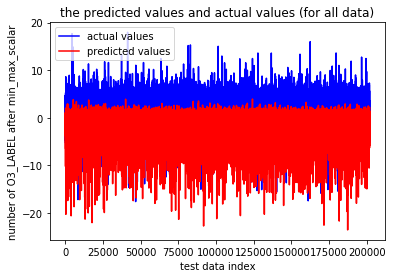

In [63]:
# plot the predicted values and actual values (for the test data)
fig, axs = plt.subplots()
axs.plot(np.squeeze(target[target>-20]), color='blue', label='actual values')
axs.plot(np.squeeze(oof), color='red', label='predicted values')
axs.set_title('the predicted values and actual values (for all data)')

plt.xlabel('test data index')
plt.ylabel('number of O3_LABEL after min_max_scalar')
plt.legend(loc='upper left')
plt.show()

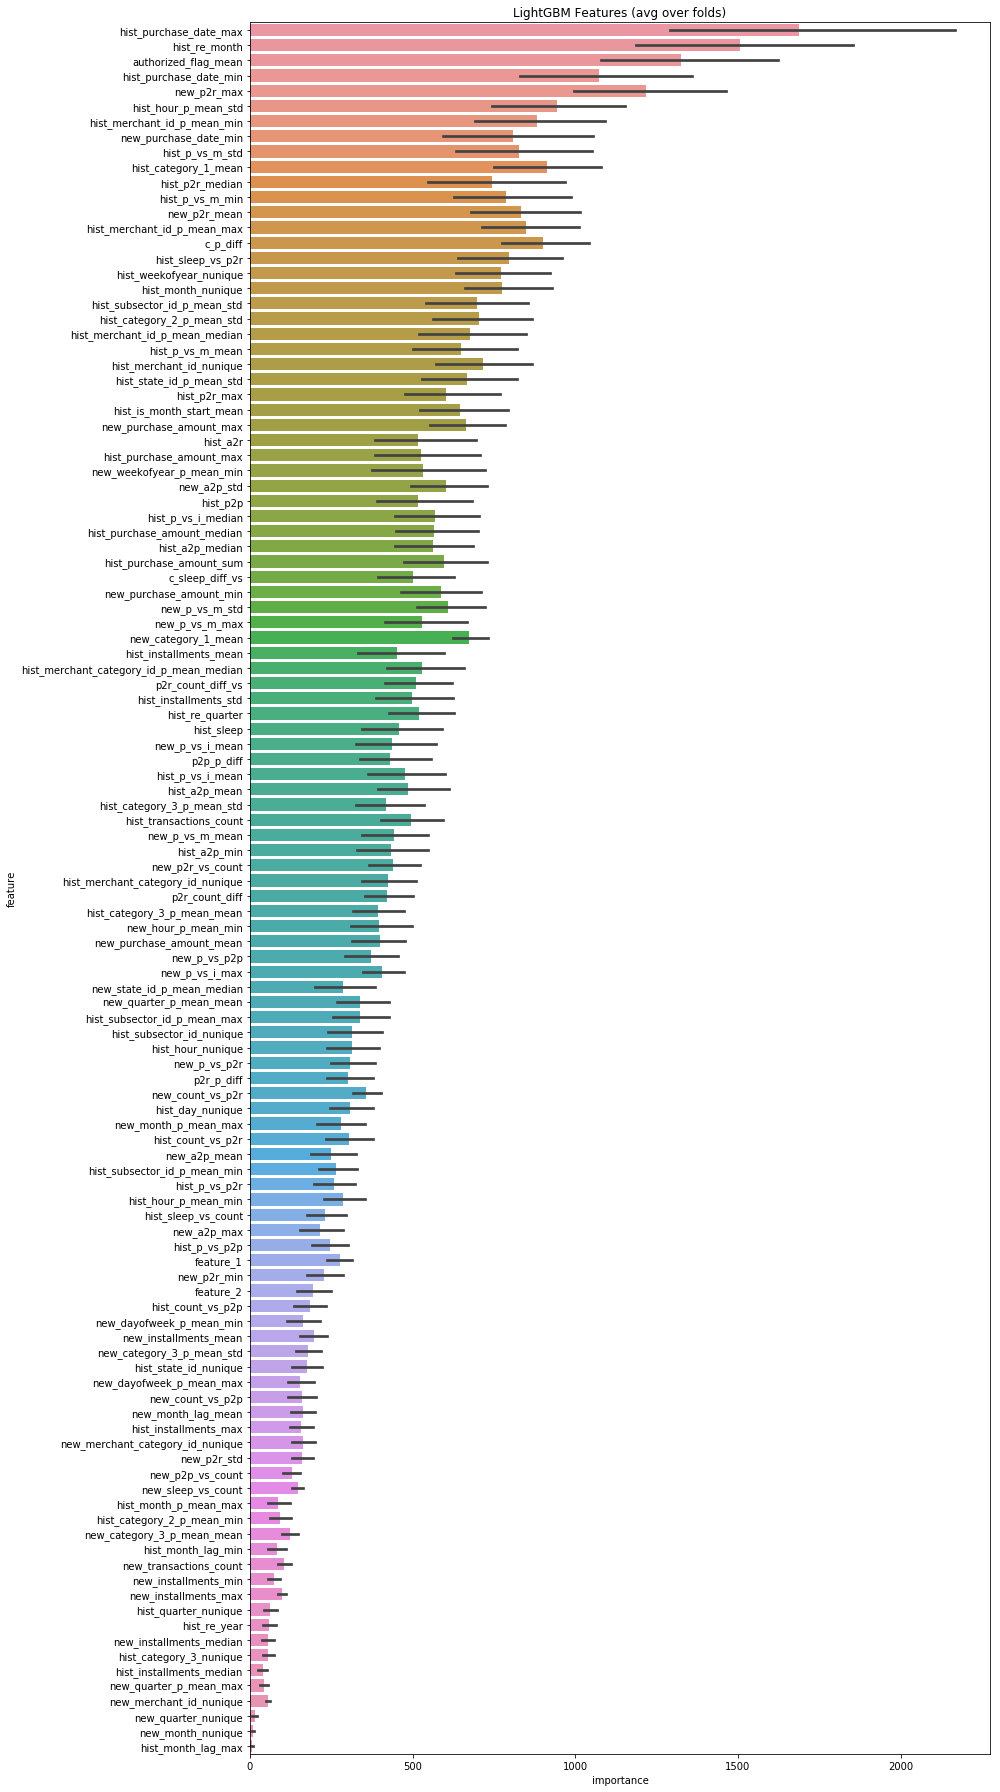

In [64]:
cols = (feature_importance_df[["feature", "importance"]]
        .groupby("feature")
        .mean()
        .sort_values(by="importance", ascending=False)[0:150].index)

best_features = feature_importance_df.loc[feature_importance_df.feature.isin(cols)]

plt.figure(figsize=(14,25))
sns.barplot(x="importance",
            y="feature",
            data=best_features.sort_values(by="importance",
                                           ascending=False))
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()
plt.savefig('lgbm_importances.png')

In [65]:
folds = StratifiedKFold(n_splits=n_fold, shuffle=True, random_state=4950)

oof_2 = np.zeros(len(train))
predictions_2 = np.zeros(len(test))

# feature_importance_df = pd.DataFrame()

target = train['target']

for fold_, (trn_idx, val_idx) in enumerate(folds.split(train, fold_target)):
    print("fold n°{}".format(fold_))
    trn_data = lgb.Dataset(train.iloc[trn_idx][features], label=target.iloc[trn_idx], categorical_feature=cat_feats)
    val_data = lgb.Dataset(train.iloc[val_idx][features], label=target.iloc[val_idx], categorical_feature=cat_feats)
#     trn_data = lgb.Dataset(train.iloc[trn_idx][features], label=target.iloc[trn_idx])
#     val_data = lgb.Dataset(train.iloc[val_idx][features], label=target.iloc[val_idx])
    num_round = 10000
    clf = lgb.train(param, trn_data, num_round, valid_sets = [trn_data, val_data],
                    verbose_eval=100, early_stopping_rounds = 200)
    oof_2[val_idx] = clf.predict(train.iloc[val_idx][features], num_iteration=clf.best_iteration)
    
#     fold_importance_df = pd.DataFrame()
#     fold_importance_df["feature"] = features
#     fold_importance_df["importance"] = clf.feature_importance()
#     fold_importance_df["fold"] = fold_ + 1
#     feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    predictions_2 += clf.predict(test[features], num_iteration=clf.best_iteration) / folds.n_splits

fold n°0
Training until validation scores don't improve for 200 rounds.
[100]	training's rmse: 3.65398	valid_1's rmse: 3.70822
[200]	training's rmse: 3.57307	valid_1's rmse: 3.67528
[300]	training's rmse: 3.52152	valid_1's rmse: 3.66284
[400]	training's rmse: 3.48341	valid_1's rmse: 3.65625
[500]	training's rmse: 3.45339	valid_1's rmse: 3.65232
[600]	training's rmse: 3.42838	valid_1's rmse: 3.65008
[700]	training's rmse: 3.40506	valid_1's rmse: 3.64853
[800]	training's rmse: 3.38271	valid_1's rmse: 3.64799
[900]	training's rmse: 3.36249	valid_1's rmse: 3.64713
[1000]	training's rmse: 3.3434	valid_1's rmse: 3.64715
[1100]	training's rmse: 3.32535	valid_1's rmse: 3.64683
[1200]	training's rmse: 3.30865	valid_1's rmse: 3.64616
[1300]	training's rmse: 3.2916	valid_1's rmse: 3.64603
[1400]	training's rmse: 3.27628	valid_1's rmse: 3.64584
[1500]	training's rmse: 3.26066	valid_1's rmse: 3.64586
[1600]	training's rmse: 3.24453	valid_1's rmse: 3.64588
Early stopping, best iteration is:
[1403]	t

In [66]:
print("CV score: {:<8.5f}".format(mean_squared_error(oof_2, target)**0.5))

CV score: 3.63993 


In [70]:
test_target = pd.read_csv("./data/test.csv")

In [71]:
sub_df = pd.DataFrame({"card_id":test_target["card_id"].values})
sub_df["target"] = predictions
sub_df.to_csv("submission.csv", index=False)

In [72]:
sub_df = pd.DataFrame({"card_id":test_target["card_id"].values})
sub_df["target"] = predictions_2
sub_df.to_csv("submission_2.csv", index=False)